In [1]:
from pathlib import Path
from os.path import join
import pandas as pd
import numpy as np
from numpy.random import choice, randint, uniform, randn
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import ipyvolume as ipv
import ipyvolume.pylab as p3
from ipywidgets import HBox
from sklearn.datasets import fetch_mldata, make_swiss_roll, make_s_curve
from sklearn.manifold import locally_linear_embedding
from sklearn.decomposition import PCA
#from plotly.offline import init_notebook_mode, iplot
#from plotly.graph_objs import *
#import colorlover as cl

In [2]:
%matplotlib inline
plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='talk', fscale=1.4, spines=False, 
             gridlines='--', ticks=True, grid=False, figsize=(14, 8))
#init_notebook_mode(connected=True)

### Manifold Examples

#### Linear Manifold: Ellipse in 3D 

In [3]:
n_points, noise = 1000, 0.1
angles = uniform(low=-np.pi, high=np.pi, size=n_points)
x = 2 * np.cos(angles) + noise * randn(n_points)
y = np.sin(angles) + noise * randn(n_points)

theta = np.pi/4 # 45 degree rotation
rotation_matrix = np.array([[np.cos(theta), -np.sin(theta)], 
                            [np.sin(theta), np.cos(theta)]])

rotated = np.column_stack((x, y)).dot(rotation_matrix)
x, y = rotated[:, 0], rotated[:, 1]

z = .2 * x  + .2 * y + noise * randn(n_points)
ellipse3d = np.vstack((x, y, z)).T

#### PCA: Linear Dimensionality Reduction

This will do what we want when the lower dimensional space occupied by the points is linear

We will project the data from the 3D situation to 2D using PCA 

In [4]:
def get_2d_projection(data, pc):
    min_, max_ = data[:, :2].min(0), data[:, :2].max(0)
    X, Y = np.meshgrid(np.linspace(min_[0], max_[0], 50),
                       np.linspace(min_[1], max_[1], 50))

    nv = np.cross(pc.components_[0], pc.components_[1])
    d = -pc.mean_.dot(nv)
    Z = (-nv[0] * X - nv[1] * Y - d) * 1 / nv[2]
    factor = max(data[:, -1].min() / Z.min(), data[:, -1].max()/Z.max())
    return X, Y, Z * factor

In [5]:
pca = PCA(n_components=2)
ellipse2d = pca.fit_transform(ellipse3d)

In [6]:
znorm = z - z.min()
znorm /= znorm.ptp()
color = cm.viridis(znorm)

xs, ys, zs = get_2d_projection(ellipse3d, pca)
p3.figure(width=600, height=600)
p3.plot_wireframe(xs, ys, zs, color="black")
p3.scatter(x, y, z, marker='sphere', color=color[:,0:3], size=1)
p3.view(azimuth=45, elevation=75)
p3.show()

### Swiss Roll Example

In [7]:
n_samples = 10000
palette = sns.color_palette('viridis', n_colors=n_samples)
zeros = np.zeros(n_samples) + .5

In [8]:
swiss_3d, swiss_val = make_swiss_roll(
    n_samples=n_samples, noise=.1, random_state=42)

swiss_3d = swiss_3d[swiss_val.argsort()[::-1]]
x, y, z = swiss_3d.T 

In [9]:
p3.figure()
p3.scatter(np.sort(swiss_val), y, zeros, marker='sphere', color=palette, size=1)
p3.xlim(swiss_val.min(), swiss_val.max())
fig = p3.gcc()

In [10]:
HBox([
    ipv.quickscatter(x, y, z, size=1, color=palette, marker='sphere'),
    fig
])

#### Linear cuts along the axes

This is the simplest approach where we just remove one of the dimensions. However the problem here is that 

In [15]:
p3.figure(width=600, height=600)
p3.scatter(zeros, y, z, marker='sphere', color=palette, size=1)
p3.view(azimuth=15, elevation=45)
fig1 = p3.gcc()

In [16]:
p3.figure(width=600, height=600)
p3.scatter(x, zeros, z, marker='sphere', color=palette, size=1)
p3.view(azimuth=15, elevation=45)
fig2 = p3.gcc()

In [17]:
p3.figure(width=600, height=600)
p3.scatter(x, y, zeros, marker='sphere', color=palette, size=1)
p3.view(azimuth=15, elevation=45)
fig3 = p3.gcc()

In [18]:
HBox([
    fig1, fig2, fig3]
)

#### Principal Component Analysis

This is not good either because the linear approximation is not appropriate here

In [19]:
pca= PCA(n_components=2)
swiss_2d = pca.fit_transform(swiss_3d)

In [20]:
p3.figure(width=600, height=600)
xs, ys, zs = get_2d_projection(swiss_3d, pca)
p3.plot_wireframe(xs, ys, zs, color='black')
p3.scatter(*swiss_3d.T, marker='sphere', color=palette, size=1)
p3.view(azimuth=15, elevation=45)
fig1 = p3.gcc()

In [21]:
p3.figure(width=600, height=600)

min_2d, max_2d = swiss_2d[:, :2].min(0), swiss_2d[:, :2].max(0)
x2d, y2d = np.meshgrid(np.linspace(min_2d[0], max_2d[0], 100),
                     np.linspace(min_2d[1], max_2d[1], 100))
p3.plot_wireframe(x2d, y2d, np.zeros(shape=(100, 100)) + .5, color='black'),

p3.scatter(*np.c_[swiss_2d, np.zeros(n_samples) + .5].T,
           marker='sphere', color=palette, size=1)
p3.view(azimuth=45, elevation=45)
fig2 = p3.gcc()

In [22]:
HBox([
fig1, fig2]
)

### But will manifold learning simplify the task at hand?

In this case, separation is not possible in the projected space because the classes get split in an unfoavorable fashion

In [23]:
cpos, cneg = cm.viridis(0)[:3], cm.viridis(.999)[:3]
positive_class = swiss_3d[:, 0] > 4
X_pos = swiss_3d[positive_class]
X_neg = swiss_3d[~positive_class]

In [24]:
p3.figure(width=600, height=600)
p3.scatter(*X_pos.T, marker='sphere', color=cpos, size=1)
p3.scatter(*X_neg.T, marker='sphere', color=cneg, size=1)
p3.view(azimuth=15, elevation=45)
fig1 = p3.gcc()

In [25]:
p3.figure(width=600, height=600)
p3.scatter(np.sort(swiss_val)[positive_class], X_pos[:, 1], zeros,marker='sphere', color=cpos, size=1)
p3.scatter(np.sort(swiss_val)[~positive_class], X_neg[:, 1], zeros,marker='sphere', color=cneg, size=1)
p3.view(azimuth=15, elevation=45)
fig2 = p3.gcc()

In [26]:
HBox([fig1, fig2])

#### However in this case it works well - if the data is distributed like this in high dimensions then it will be difficult to classify. But if it is unrolled the classes can be more easly separated

In [28]:
positive_class = 2 * (np.sort(swiss_val) - 4) > swiss_3d[:, 1]
X_pos = swiss_3d[positive_class]
X_neg = swiss_3d[~positive_class]

In [29]:
p3.figure(width=600, height=600)
p3.scatter(*X_pos.T, marker='sphere', color=cpos, size=1)
p3.scatter(*X_neg.T, marker='sphere', color=cneg, size=1)
p3.view(azimuth=15, elevation=45)
fig1 = p3.gcc()

In [30]:
p3.figure(width=600, height=600)
p3.scatter(np.sort(swiss_val)[positive_class], X_pos[:, 1], zeros,marker='sphere', color=cpos, size=1)
p3.scatter(np.sort(swiss_val)[~positive_class], X_neg[:, 1], zeros,marker='sphere', color=cneg, size=1)
p3.view(azimuth=15, elevation=45)
fig2 = p3.gcc()

In [31]:
HBox([fig1, fig2])

#### Local-Linear Embedding

These are the sorts of datasets where local linear enbedding is really good

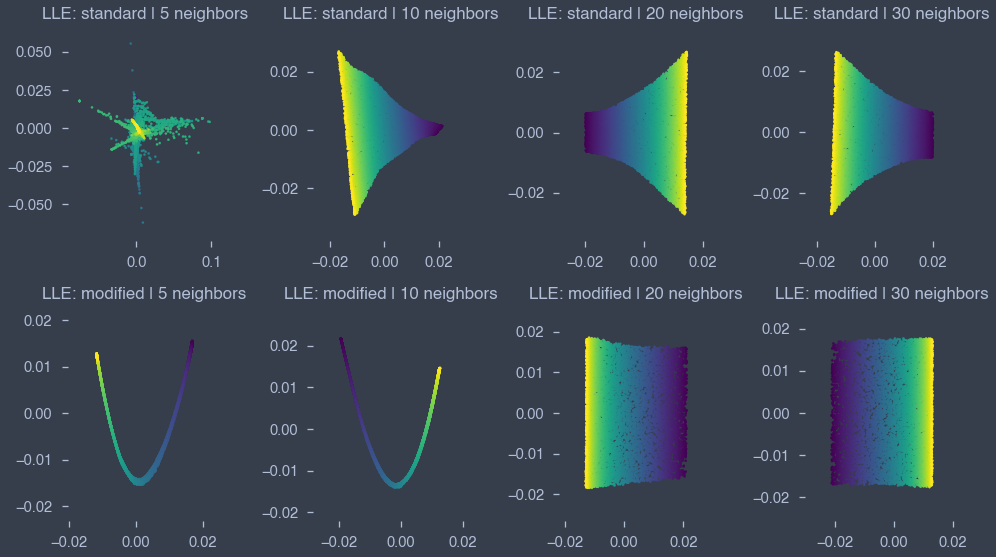

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8))
for row, method in enumerate(['standard', 'modified']):
    for col, n_neighbors in enumerate([5, 10, 20, 30]):
        embedded, err = locally_linear_embedding(swiss_3d, n_neighbors=n_neighbors, n_components=2,
                                                 method=method, random_state=42)
        axes[row, col].scatter(*embedded.T, c=palette, s=5)
        axes[row, col].set_title('LLE: {} | {} neighbors'.format(method, n_neighbors))
fig.tight_layout()

ImportError: Missing optional dependency 'tables'.  Use pip or conda to install tables.

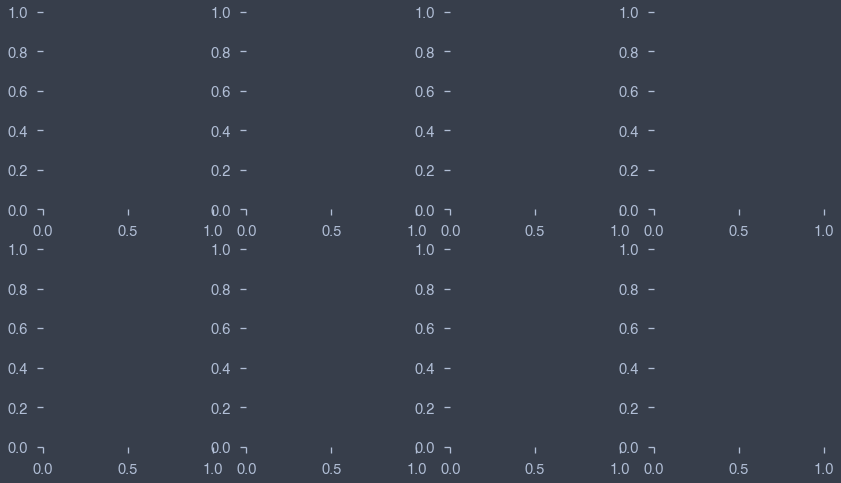

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8))
with pd.HDFStore('/'.join(['data', 'manifolds.h5'])) as store:
    for row, method in enumerate(['standard', 'modified']):
        for col, n_neighbors in enumerate([5, 10, 20, 30]):
            x, y = store.get('/'.join(['swiss', 'lle', method, str(n_neighbors)])).T.values
            axes[row, col].scatter(x, y, c=palette, s=5)
            axes[row, col].set_title('LLE: {} | {} neighbors'.format(method, n_neighbors))
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8))
with pd.HDFStore('/'.join(['data', 'manifolds.h5'])) as store:
    for row, method in enumerate(['standard', 'modified']):
        for col, n_neighbors in enumerate([5, 10, 20, 30]):
            x, y = store.get('/'.join(['swiss', 'lle', method, str(n_neighbors)])).T.values * 100
            axes[row, col].scatter(x, y, c=palette, s=5)
            axes[row, col].set_title('LLE: {} | {} neighbors'.format(method, n_neighbors))
fig.tight_layout()

### S-Curve Example

In [21]:
scurve_3d, scurve_val = make_s_curve(
    n_samples=n_samples, noise=.05, random_state=42)
scurve_3d = scurve_3d[scurve_val.argsort()[::-1]]
scurve_3d[:, 1] *= 10

In [22]:
pca = PCA(n_components=2)
scurve_2d = pca.fit_transform(scurve_3d)

In [23]:
p3.figure(width=600, height=600)
xs, ys, zs = get_2d_projection(scurve_3d, pca)
p3.plot_wireframe(xs, ys, zs, color='black')
p3.scatter(*scurve_3d.T, marker='sphere', color=palette, size=1)
p3.view(azimuth=15, elevation=45)
fig1 = p3.gcc()

In [24]:
p3.figure(width=600, height=600)

min_2d, max_2d = scurve_2d[:, :2].min(0), scurve_2d[:, :2].max(0)
x2d, y2d = np.meshgrid(np.linspace(min_2d[0], max_2d[0], 100),
                     np.linspace(min_2d[1], max_2d[1], 100))
p3.plot_wireframe(x2d, y2d, np.zeros(shape=(100, 100)) + .5, color='black'),

p3.scatter(*np.c_[scurve_2d, np.zeros(n_samples) + .5].T,
           marker='sphere', color=palette, size=1)
p3.view(azimuth=45, elevation=45)
fig2 = p3.gcc()

In [25]:
#The one on the left is the data plus the surface found by PCA. The one on the right is the result of the data being 
#projected onto the surface

HBox([
fig1, fig2]
)

#### Local-Linear Embedding

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8))
for row, method in enumerate(['standard', 'modified']):
    for col, n_neighbors in enumerate([5, 10, 20, 30]):
        embedded, err = locally_linear_embedding(scurve_3d,
                                                 n_neighbors=n_neighbors,
                                                 n_components=2,
                                                 method=method,
                                                 random_state=42)
        axes[row, col].scatter(*embedded.T, c=palette, s=5)
        axes[row, col].set_title('LLE: {} | {} neighbors'.format(method, n_neighbors))
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8))
with pd.HDFStore('/'.join(['data', 'manifolds.h5'])) as store:
    for row, method in enumerate(['standard', 'modified']):
        for col, n_neighbors in enumerate([5, 10, 20, 30]):
            x, y = store.get('/'.join(['scurve', 'lle', method, str(n_neighbors)])).T.values * 100
            axes[row, col].scatter(x, y, c=palette, s=5)
            axes[row, col].set_title('LLE: {} | {} neighbors'.format(method, n_neighbors))
fig.tight_layout()

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8))
with pd.HDFStore('manifold_comparison.h5') as store:
    for row, method in enumerate(['standard', 'modified']):
        for col, n_neighbors in enumerate([5, 10, 20, 30]):
            embedded, err = locally_linear_embedding(scurve_3d,
                                                     n_neighbors=n_neighbors,
                                                     n_components=2,
                                                     method=method,
                                                     random_state=42)
            axes[row, col].scatter(*embedded.T, c=palette, s=5)
            axes[row, col].set_title(
                'LLE: {} | {} neighbors'.format(method, n_neighbors))
fig.tight_layout()

### Handwritten Digits

In [ ]:
mnist = fetch_mldata('MNIST original', data_home='.')
mnist.data.shape

In [ ]:
classes = sorted(np.unique(mnist.target).astype(int))
classes

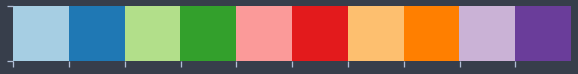

In [41]:
ipv_cmap = sns.color_palette("Paired", n_colors=10)
sns.palplot(ipv_cmap)

#### Plot sample images

In [ ]:
image_size = int(np.sqrt(mnist.data.shape[1])) # 28 x 28 pixels
n_samples = 15

In [ ]:
fig, ax = plt.subplots()
mnist_sample = np.empty(
    shape=(image_size * len(classes), image_size * n_samples))
for row, label in enumerate(classes):
    label_data = np.squeeze(np.argwhere(mnist.target == label))
    samples = choice(label_data, size=n_samples, replace=False)
    i = row * image_size
    for col, sample in enumerate(samples):
        j = col * image_size
        mnist_sample[i:i+image_size, j:j +
                     image_size] = mnist.data[sample].reshape(image_size, -1)

ax.imshow(mnist_sample, cmap='Blues')
plt.title('Handwritten Digits')
plt.axis('off')
plt.tight_layout()

### Linear Dimensionality Reduction

In [ ]:
pca = PCA(n_components=2)
mnist_pca_2d = pca.fit_transform(mnist.data)
ev = pca.explained_variance_ratio_

In [ ]:
plotly_cmap = cl.to_rgb( cl.scales['10']['qual']['Paired'])
def plotly_scatter(data, label, title, color, x='x', y='y'):
    fig = dict(
        data=[
            dict(
                type='scattergl',
                x=data[:, 0],
                y=data[:, 1],
                legendgroup="group",
                text=label.astype(int),
                mode='markers',
                marker=Marker(
                    size=5,
                    color=color,
                    autocolorscale=False,
                    showscale=False,
                    opacity=.9,
                    colorbar=ColorBar(
                        title='Class'
                    ),
                    line=dict(width=1))),
        ],
        layout=dict(title=title,
                    width=1200,
                    font=dict(color='white'),
                    xaxis=dict(
                        title=x, 
                        hoverformat='.1f', 
                        showgrid=False),
                    yaxis=dict(title=y, 
                               hoverformat='.1f', 
                               showgrid=False),
                    paper_bgcolor='rgba(0,0,0,0)',
                    plot_bgcolor='rgba(0,0,0,0)'
                    ))

    iplot(fig, show_link=False)

In [ ]:
plotly_color = [plotly_cmap[int(i)] for i in mnist.target]
plotly_scatter(data=mnist_pca_2d, 
               title='MNIST PCA Projection',
               label=mnist.target,
               color=plotly_color,
               x='1st Principal Component: {:.2%}'.format(ev[0]), 
               y='Second Principal Component: {:.2%}'.format(ev[1]))

In [ ]:
pca = PCA(n_components=3)
mnist_3d = pca.fit_transform(mnist.data)
pd.Series(pca.explained_variance_ratio_)

In [ ]:
ipv_color = [ipv_cmap[int(t)] for t in mnist.target]
ipv.quickscatter(*mnist_3d.T, size=.5, color=ipv_color, marker='sphere')

#### Local Linear Embedding: Standard

The following `locally_linear_embedding` on `mnist.data` takes fairly long to run, hence we are providing pre-computed results so you can explore the visualizations regardless of your hardware setup.

In [ ]:
# the pre-computed manifold results for the various datasets and numerous parameter settings are here:
with pd.HDFStore(join('data', 'manifolds.h5')) as store:
    print(store.info())

In [ ]:
# commented out to avoid long run time
# lle, err = locally_linear_embedding(X=mnist.data, n_components=2, n_neighbors=20, method='standard')

In [ ]:
def get_result(source, method, params):
    key = '/'.join([source, method, '/'.join([str(p) for p in params])])
    with pd.HDFStore('/'.join(['data', 'manifolds.h5'])) as store:
        data = store[key].values
        labels = store['/'.join([source, 'labels'])]
    return data, labels

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4)
with pd.HDFStore(join('data', 'manifolds.h5')) as store:
    labels = store.get('/'.join(['mnist', 'labels']))
    color = [sns.color_palette('Paired', 10)[int(i)] for i in labels]
    for row, method in enumerate(['standard', 'modified']):
        for col, n_neighbors in enumerate([20, 50, 100, 200]):
            try:
                x, y = store.get('/'.join(['mnist', 'lle', method, '2', str(n_neighbors)])).T.values
            except:
                x, y = store.get('/'.join(['mnist', 'lle', '2', str(n_neighbors)])).T.values
            axes[row, col].scatter(x, y, c=color, s=5)
            axes[row, col].set_title('LLE: {} | {} neighbors'.format(method, n_neighbors))
fig.tight_layout()  

In [ ]:
params = ['standard', 2, 100]
embedding, labels = get_result('mnist', 'lle', params)
color = [plotly_cmap[int(i)] for i in labels]
plotly_scatter(embedding, labels, color=color, title='Local Linear Embedding (Standard) | 100 Neighbors')

### Load Fashion MNIST Data

In [34]:
fashion_mnist = pd.read_csv(Path('data') / 'fashion-mnist_train.csv.gz')
fashion_label = fashion_mnist.label
fashion_data = fashion_mnist.drop('label', axis=1).values
classes = sorted(np.unique(fashion_label).astype(int))

In [35]:
image_size = int(np.sqrt(fashion_data.shape[1])) # 28 x 28 pixels
n_samples = 15

/Users/rmartinshort/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  return bound(*args, **kwds)


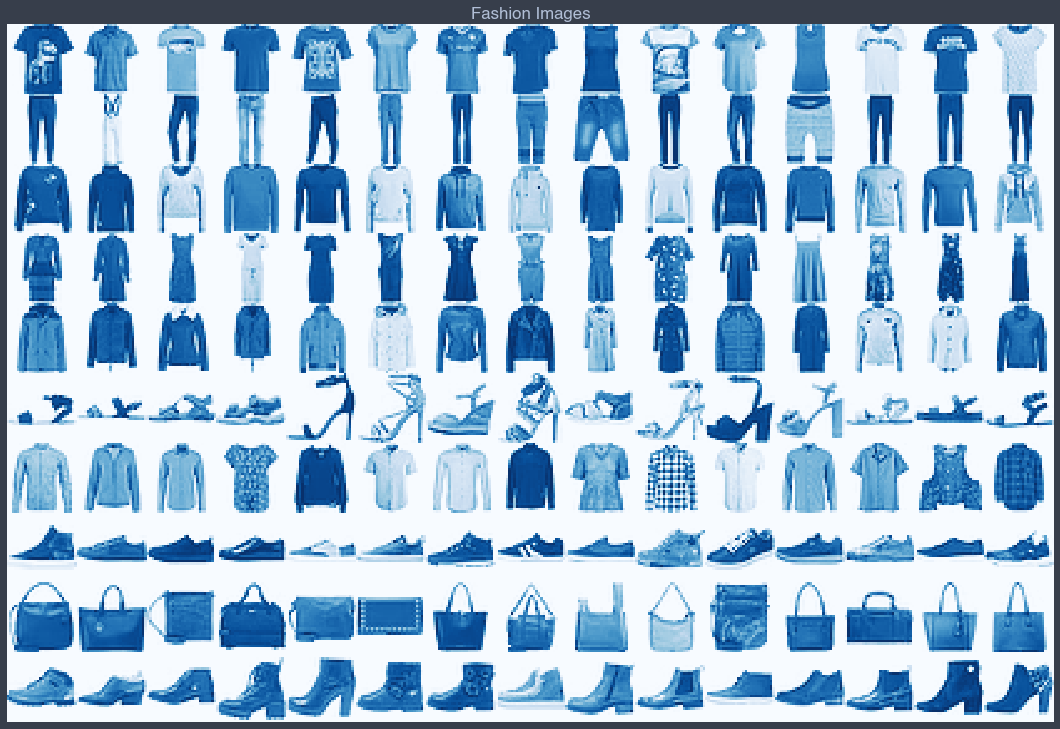

In [36]:
fig, ax = plt.subplots()
fashion_sample = np.empty(shape=(image_size * len(classes),
                               image_size * n_samples))
for row, label in enumerate(classes):
    label_data = np.squeeze(np.argwhere(fashion_label == label))
    samples = choice(label_data, size=n_samples, replace=False)
    i = row * image_size
    for col, sample in enumerate(samples):
        j = col * image_size
        fashion_sample[i:i+image_size,
                     j:j + image_size] = fashion_data[sample].reshape(image_size, -1)

ax.imshow(fashion_sample, cmap='Blues')
plt.title('Fashion Images')
plt.axis('off')
plt.tight_layout();

In [37]:
pca = PCA(n_components=2)
fashion_pca_2d = pca.fit_transform(fashion_data)
ev = pca.explained_variance_ratio_
pd.Series(ev)

0   0.29
1   0.18
dtype: float64

In [ ]:
plotly_color = [plotly_cmap[int(i)] for i in fashion_label]
plotly_scatter(data=fashion_pca_2d, 
               title='Fashion MNIST PCA Projection',
               label=fashion_label,
               color=plotly_color,
               x='1st Principal Component: {:.2%}'.format(ev[0]), 
               y='Second Principal Component: {:.2%}'.format(ev[1]))

In [38]:
pca = PCA(n_components=3)
fashion_3d = pca.fit_transform(fashion_data)
pd.Series(pca.explained_variance_ratio_)

0   0.29
1   0.18
2   0.06
dtype: float64

This is not too bad! Local linear embedding might be better though

In [42]:
ipv_color = [ipv_cmap[int(t)] for t in fashion_label]
ipv.quickscatter(*fashion_3d.T, size=.5, color=ipv_color, marker='sphere')

### Local Linear Embedding

This also appears to be fairly good.

Evidently it took a long time to run the LLE with this dataset since we're loading everything from file

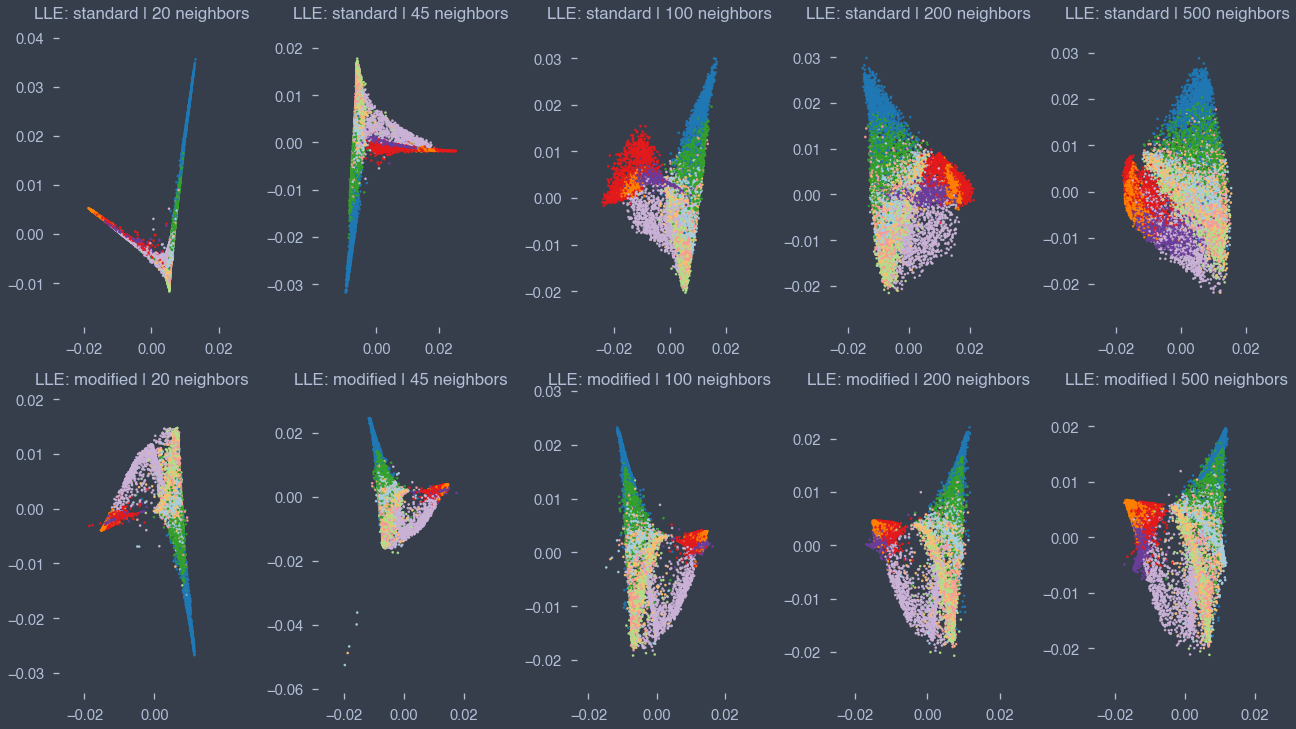

In [44]:
fig, axes = plt.subplots(nrows=2, ncols=5)
with pd.HDFStore('/'.join(['data', 'manifolds.h5'])) as store:
    labels = store.get('/'.join(['fashion', 'labels']))
    color = [sns.color_palette('Paired', 10)[int(i)] for i in labels]
    for row, method in enumerate(['standard', 'modified']):
        for col, n_neighbors in enumerate([20, 45, 100, 200, 500]):
            try:
                x, y = store.get('/'.join(['fashion', 'lle', method, '2', str(n_neighbors)])).T.values
            except:
                x, y = store.get('/'.join(['fashion', 'lle', '2', str(n_neighbors)])).T.values
            axes[row, col].scatter(x, y, c=color, s=5)
            axes[row, col].set_title('LLE: {} | {} neighbors'.format(method, n_neighbors))
fig.tight_layout()            

In [ ]:
params = ['standard', 2, 200]
embedding, labels = get_result('fashion', 'lle', params)
color = [plotly_cmap[int(i)] for i in labels]
plotly_scatter(embedding, labels, color=color, title='Local Linear Embedding (Standard) | 200 Neighbors' )